In [2]:
import pandas as pd
import numpy as np
import glob
import re
import matplotlib.pyplot as plt

In [30]:
def cargar (carpeta):
    # Cargar todos los .txt
    archivos = glob.glob(carpeta + r"\*.txt")

    datos_todos = []

    for archivo in archivos:

        # Extraer nombre base
        nombre = archivo.split("\\")[-1].replace(".txt","")

        # Extraer pH del nombre
        match = re.search(r"pH(\d+)", nombre, re.IGNORECASE)
        pH = int(match.group(1)) if match else None

        # ------------------------------------------------------------------
        #  Intento 1: leer en latin-1 (muy común)
        #  Intento 2: Windows-1252
        #  Intento 3: forzar reemplazar caracteres raros
        # ------------------------------------------------------------------
        for enc in ["latin1", "cp1252", "utf-8", "utf-8-sig"]:
            try:
                df = pd.read_csv(archivo, sep="\t", engine="python", encoding=enc)
                break
            except UnicodeDecodeError:
                continue
        else:
            # Último recurso
            df = pd.read_csv(archivo, sep="\t", engine="python", encoding="latin1", errors="replace")

        # Convertir números con coma decimal
        for c in df.columns:
            df[c] = df[c].astype(str).str.replace(",", ".")
            df[c] = pd.to_numeric(df[c], errors="ignore")

        df["pH"] = pH
        df["Archivo"] = nombre

        datos_todos.append(df)

    df_total = pd.concat(datos_todos, ignore_index=True)

    return df_total


In [32]:
datos_LL01=cargar(carpeta = r"C:\Users\lucia\Desktop\Uni\5 cuatri\Inv II\archivos\medidas zeta\LL01")
datos_LL02=cargar(carpeta = r"C:\Users\lucia\Desktop\Uni\5 cuatri\Inv II\archivos\medidas zeta\LL02")
datos_LL02_H2O=cargar(carpeta = r"C:\Users\lucia\Desktop\Uni\5 cuatri\Inv II\archivos\medidas zeta\LL02_H2O")
datos_LL02_v2=cargar(carpeta = r"C:\Users\lucia\Desktop\Uni\5 cuatri\Inv II\archivos\medidas zeta\LL02-2")


C:\Users\lucia\AppData\Local\Temp\ipykernel_22932\2428590212.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")
C:\Users\lucia\AppData\Local\Temp\ipykernel_22932\2428590212.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")
C:\Users\lucia\AppData\Local\Temp\ipykernel_22932\2428590212.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")
C:\Users\lucia\AppData\Local\Temp\ipykernel_22932\2428590212.py:34: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric witho

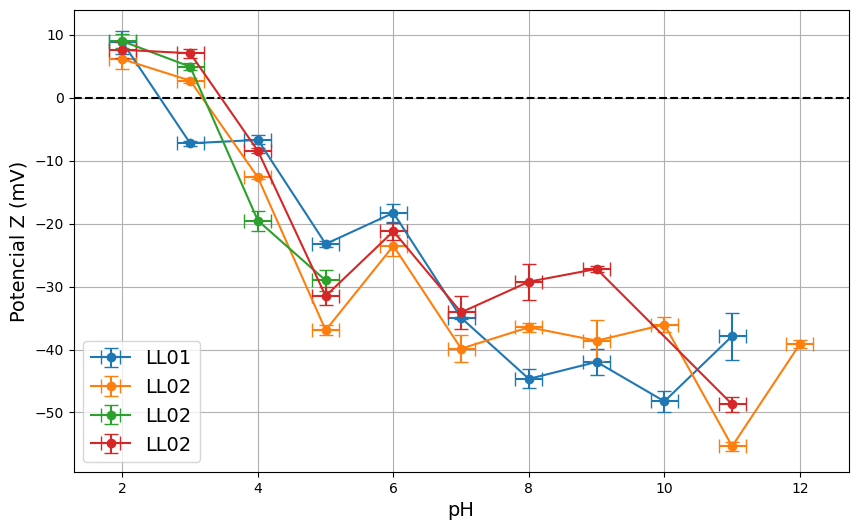

In [33]:
plt.figure(figsize=(10,6))
promedios_1 = datos_LL01.groupby("pH")["Zeta Potential (mV)"].mean()
desvios_1 = datos_LL01.groupby("pH")["Zeta Potential (mV)"].std()
plt.errorbar(promedios_1.index, promedios_1, xerr=0.2 , yerr=desvios_1,fmt="o-", capsize=5,label="LL01")

promedios_2 = datos_LL02.groupby("pH")["Zeta Potential (mV)"].mean()
desvios_2 = datos_LL02.groupby("pH")["Zeta Potential (mV)"].std()
plt.errorbar(promedios_2.index, promedios_2, xerr=0.2 , yerr=desvios_2,fmt="o-", capsize=5, label="LL02")

promedios_3 = datos_LL02_H2O.groupby("pH")["Zeta Potential (mV)"].mean()
desvios_3 = datos_LL02_H2O.groupby("pH")["Zeta Potential (mV)"].std()
plt.errorbar(promedios_3.index, promedios_3, xerr=0.2 , yerr=desvios_3,fmt="o-", capsize=5, label="LL02")

promedios_4 = datos_LL02_v2.groupby("pH")["Zeta Potential (mV)"].mean()
desvios_4 = datos_LL02_v2.groupby("pH")["Zeta Potential (mV)"].std()
plt.errorbar(promedios_4.index, promedios_4, xerr=0.2 , yerr=desvios_4,fmt="o-", capsize=5, label="LL02")

plt.axhline(0, color='black', linestyle='--')

plt.xlabel("pH", fontsize=14)
plt.ylabel("Potencial Z (mV)", fontsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.show()


# Promedio ponderado

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# ============================
# FUNCIÓN: media ponderada SIN ERRORES = 0
# ============================
def media_ponderada(valores, errores):
    # Reemplazar errores cero por un mínimo físico
    errores = np.where(errores == 0, 5, errores)

    pesos = 1 / errores**2
    mean = np.sum(valores * pesos) / np.sum(pesos)
    err = np.sqrt(1 / np.sum(pesos))
    return mean, err

# ============================
# FUNCIÓN PRINCIPAL: cargar()
# ============================
def cargar_2(carpeta):
    """
    Lee todos los archivos .txt dentro de una carpeta LL01 o LL02
    y devuelve un DataFrame con pH, media ponderada y error.
    """
    archivos = glob.glob(os.path.join(carpeta, "*.txt"))
    datos = []

    # Identificar muestra
    if "LL01" in carpeta:
        muestra = "LL01"
    elif "LL02" in carpeta:
        muestra = "LL02"
    else:
        muestra = "Desconocida"

    for archivo in archivos:
        nombre = os.path.basename(archivo)

        # Extraer pH
        try:
            pH_str = nombre.split("pH")[1]
            pH = float("".join(c for c in pH_str if c.isdigit() or c == "."))
        except:
            print(f"⚠️ No pude leer el pH en: {nombre}")
            continue

        # Leer archivo
        df = pd.read_csv(archivo, sep="\t", engine="python", encoding="latin1")

        # Convertir a números (con comas decimales)
        cols_num = ["Zeta Potential (mV)", "Zeta Deviation (mV)"]
        for col in cols_num:
            df[col] = (
                df[col]
                  .astype(str)
                  .str.replace(",", ".", regex=False)
                  .astype(float)
            )

        zeta = df["Zeta Potential (mV)"].values
        err = df["Zeta Deviation (mV)"].values

        # Media ponderada
        z_mean, z_err = media_ponderada(zeta, err)

        datos.append({
            "Muestra": muestra,
            "pH": pH,
            "Zeta_mean": z_mean,
            "Zeta_err": z_err,
            "N_medidas": len(zeta)
        })

    return pd.DataFrame(datos).sort_values("pH").reset_index(drop=True)


In [51]:
datos_LL01_2 = cargar_2(r"C:\Users\lucia\Desktop\Uni\5 cuatri\Inv II\archivos\medidas zeta\LL01")
datos_LL02_2 = cargar_2(r"C:\Users\lucia\Desktop\Uni\5 cuatri\Inv II\archivos\medidas zeta\LL02")
datos_LL02_H2O_2 = cargar_2(r"C:\Users\lucia\Desktop\Uni\5 cuatri\Inv II\archivos\medidas zeta\LL02_H2O")
datos_LL02_v2_2 = cargar_2(r"C:\Users\lucia\Desktop\Uni\5 cuatri\Inv II\archivos\medidas zeta\LL02-2")


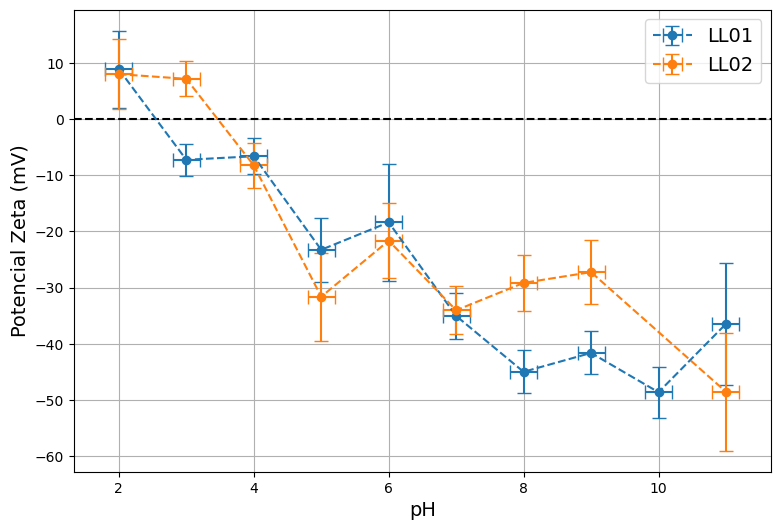

In [56]:
plt.figure(figsize=(9,6))
plt.errorbar(datos_LL01_2["pH"], datos_LL01_2["Zeta_mean"], xerr=0.2 ,yerr=datos_LL01_2["Zeta_err"],fmt="o--", capsize=5, label="LL01")
#plt.errorbar(datos_LL02_2["pH"], datos_LL02_2["Zeta_mean"], xerr=0.2 , yerr=datos_LL02_2["Zeta_err"],fmt="o--", capsize=5, label="LL02")
#plt.errorbar(datos_LL02_H2O["pH"], datos_LL02_H2O["Zeta_mean"], xerr=0.2 , yerr=datos_LL02_H2O["Zeta_err"],fmt="o--", capsize=5, label="LL02_H2O")
plt.errorbar(datos_LL02_v2_2["pH"], datos_LL02_v2_2["Zeta_mean"], xerr=0.2 , yerr=datos_LL02_v2_2["Zeta_err"],fmt="o--", capsize=5, label="LL02")

plt.axhline(0, color="black", linestyle="--")
plt.xlabel("pH", fontsize=14)
plt.ylabel("Potencial Zeta (mV)", fontsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.show()
